# AUTO-PLATE-RECOGNITION
#### UCLA CS145 - Professor Si Si
#### TEAM NAME: Deep Learners
----
#### TEAM MEMBERS:
Caleb Lee   UID: 305-330-193    Email: bkcaleb45@g.ucla.edu 

Dylan Phe	UID: 505-834-475	Email: dylanphe@g.ucla.edu

Kevin Wang	UID:  305-503-382      Email: kwang1083@g.ucla.edu

---

Our project focuses on utilizing machine learning algorithms, which we have learned in class and through further research, to classify the names of states that appear on license plates from the 50 U.S. states, including Washington D.C. The main objective is to construct and train models capable of effectively performing this classification task. Throughout the project, we will compare the performances of different machine learning models, taking into consideration their complexity, training times, and memory efficiency. To evaluate and compare the models, we will employ metrics such as F1 Scores and accuracy. Furthermore, we will train and test the performance of these algorithms on a diverse dataset of license plate images, encompassing various lighting conditions, environments, and sizes.

## I. Importing the necessary packages

Packages like NumPy, pandas, matplotlib, cv2, and scipy are utlized to help us prepare the dataset as well as pre-processing them before the classification task. In addition, an open source software library, Keras, is also used to help us construct various training models for making predictions and analyzing their outcomes. As a means to mitigate the performance and memory consumption issue on our machines, we decided to work within a Colab notebook environment. Hence, it is required to use google.colab library so that we can import relevant files from our google drive storage to be used within this notebook.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Navigate to the current working directory.

In [2]:
%cd '/content/drive/MyDrive/AUTO-PLATE/auto-plate-detector-main'

/content/drive/MyDrive/AUTO-PLATE/auto-plate-detector-main


In [3]:
import os
import random
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import cv2
from scipy.ndimage import gaussian_filter
from keras.models import Sequential, Model
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## II. Preparing and Pre-Procesing the Dataset

### 2.(a). Loading and Visualizing the dataset 

To construct our dataset, we gathered a total of 3,279 images of license plates from all 51 U.S. states. These images were obtained from the following sources:

Kaggle:  https://www.kaggle.com/code/tolgadincer/us-license-plates-data-quick-overview/input?select=data

Platesmania: https://platesmania.com/us/gallery-1

Once collected, we organized the data into a table format with dimensions 3,279x2, which we saved as a CSV file named "file_list.csv". Each entry in the table contains two attributes, namely "Label" and "Image", which serve to identify each image file along with its corresponding label. Furthermore, we split the dataset into a training dataset and a testing dataset, which were saved as separate CSV files named "train_data.csv" and "test_data.csv", respectively. This division ensures that we have distinct sets of data for training our models and evaluating their performance. It's worth noting that the process of organizing the data and splitting it into training and testing datasets was performed outside the Google Colab environment.

In [ ]:
# Directory path
dataset_path = 'dataset'

# CSV file path
csv_file = 'file_list.csv'
test_data_file = 'test_data.csv'
train_data_file = 'train_data.csv'

# Function to get the file list in a directory
def get_file_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(file)
    return file_list

# Check if the CSV files already exist
csv_file_exists = os.path.exists(csv_file)
test_data_file_exists = os.path.exists(test_data_file)
train_data_file_exists = os.path.exists(train_data_file)

# Generate CSV file if it doesn't exist
if not csv_file_exists:
    # Get directory list in /dataset
    directories = [directory for directory in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, directory))]

    # Open the CSV file in write mode
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Iterate through directories
        for directory in directories:
            # Get file list in the current directory
            file_list = get_file_list(os.path.join(dataset_path, directory))

            # Write file list to CSV
            for file_name in file_list:
                writer.writerow([directory, file_name])

    print("CSV file generated successfully.")
else:
    print("CSV file already exists. Skipping generation.")

# Read the data from the original CSV file if it exists
data = []
if csv_file_exists:
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            data.append(row)

    # Shuffle the data randomly
    random.shuffle(data)

    # Calculate the split index
    split_index = int(len(data) * 9 / 10)

    # Split the data into test and train sets
    train_data = data[:split_index+1]
    test_data = data[split_index:]

    # Write test data to CSV if it doesn't exist
    if not test_data_file_exists:
        with open(test_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(test_data)
        print("Test data CSV file generated successfully.")
    else:
        print("Test data CSV file already exists. Skipping generation.")

    # Write train data to CSV if it doesn't exist
    if not train_data_file_exists:
        with open(train_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(train_data)
        print("Train data CSV file generated successfully.")
    else:
        print("Train data CSV file already exists. Skipping generation.")

    print("Data separation completed successfully.")


CSV file already exists. Skipping generation.
Test data CSV file already exists. Skipping generation.
Train data CSV file already exists. Skipping generation.
Data separation completed successfully.


After the csv files were created, we utilized pandas to read both the train_data.csv and the test_data.csv and converted them into train and test dataframes as shown below. The training dataframe should contain 2951 rows whereas the testing dataset should contain 328 rows. The proportion of the split is 9:1.

In [4]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print(f"Training data = {train.shape}")
print(f"Testing data = {test.shape}")
train

Training data = (2951, 2)
Testing data = (328, 2)


,Label,Image
0,Missouri,c2279f4a173509.jpg
1,SouthDakota,e0a2bee82c7b29.jpg
2,Pennsylvania,4dc2772e7e3ddd.jpg
3,Massachusetts,21685515aa4999.png
4,Delaware,ae03d6f2677fa4.jpg
...,...,...
2946,Michigan,21680287dfe37d.png
2947,Florida,21572733ecdb1b.png
2948,Washington,4ed9656a5fd7b4.jpg
2949,Virginia,b1b47d79cd01b9.jpg


Given the tables above, we can easily obtain the image files and its corresponding true labels from the dataframes while also being able to distinguish between the two for the purposes of trainings and making predictions. The code below is written and executed as a mean to visualize our dataset.

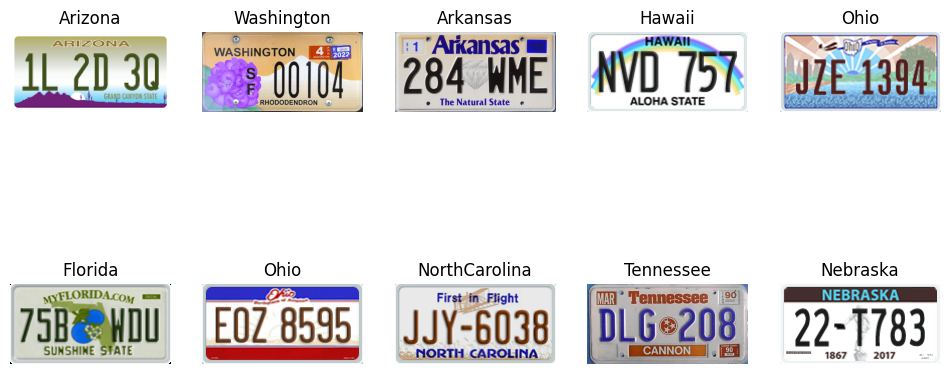

In [ ]:
random.seed(2)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = '/content/drive/MyDrive/auto-plate-detector/dataset/' + train.loc[idx, 'Label'] + '/' + train.loc[idx, 'Image']
    img = cv2.imread(path)
    ax[i].imshow(img)
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
plt.show()

### 2.(b) Pre-Processing and Spliting the dataset into the training, validation, and test datasets

To enhance the visibility of the State's name letters against the background in our image dataset, we employ several pre-processing steps:

- Resizing: We resize all the images in the dataset to have the same dimensions.

- Increasing Image Intensity: We use the convertScaleAbs() function with an alpha value of 1 and a beta value of 2. This adjustment increases the overall brightness of the image, enhancing the visibility of the letters.

- Grayscale Conversion: We convert the images from their original color format to grayscale. This conversion simplifies the images by removing color information and focusing solely on the grayscale intensity values. It helps reduce the complexity of the data while retaining important contrast details.

- Region Isolation: Since the State's names are typically located at the top or bottom of the license plate, we isolate these specific regions of interest in the images. By focusing on these regions, we can concentrate our training efforts on the areas where the State's names commonly appear. This step helps improve the model's ability to learn and recognize the State's names accurately.

- Image Enhancement: We apply an additional enhancement step to optimize the visibility of the letters. If the images reach a certain threshold where the contrast between the letters and the background is low, we invert the colors between the white and dark parts of the images. This inversion further enhances the distinction between the State's name letters and the background.

- Normalization: Finally, we normalize the pre-processed images. Normalization ensures that the pixel values are scaled to a consistent range, typically between 0 and 1 or -1 and 1. This step helps standardize the input data, making it more suitable for training machine learning models.

By following these pre-processing steps, we enhance the visibility of the State's name letters against the license plate backgrounds, facilitating subsequent analysis and improving the accuracy of our machine learning models by at least 40-50%.

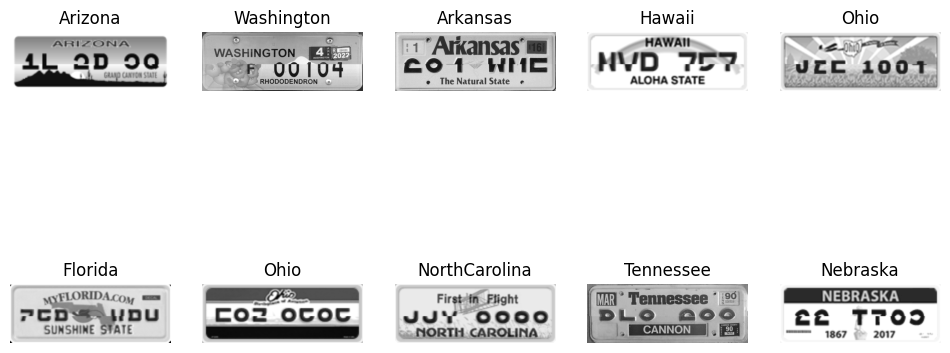

In [ ]:
random.seed(2)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = '/content/drive/MyDrive/auto-plate-detector/dataset/' + train.loc[idx, 'Label'] + '/' + train.loc[idx, 'Image']
    img = cv2.imread(path)
    img = cv2.resize(img, (1000, 500))
    
    img = cv2.convertScaleAbs(img, alpha=1, beta=2)
    
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the height of the image
    height = img.shape[0]
    
    # Cut the image in half
    top_img = gray_img[0:int((height/2.5)), :]
    bottom_img = gray_img[int(2*(height/3)):height, :]
    
    concat_img = np.concatenate((top_img, bottom_img), axis=0)
    
    # Calculate the average brightness of the image
    average_brightness = np.mean(concat_img)
    
    # Define threshold values for brightness adjustment
    dark_threshold =   60# Adjust this value to determine what is considered dark
    
    if average_brightness < dark_threshold:
        # Invert the dark and light parts of the image
        concat_img = cv2.bitwise_not(concat_img)
        
    # Increase the contrast between letters and background
    #concat_img = cv2.bitwise_not(concat_img)
    enhanced_img = cv2.normalize(concat_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    ax[i].imshow(enhanced_img, cmap='gray')
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
    #ax[i].imshow(binary_img, cmap='gray')
    #ax[i].set_title(train.loc[idx, 'Label'])
    #ax[i].axis('off')

plt.show()

To prepare our dataset for the training and the prediction stages, we parse the images and append them to their corresponding row within dataframes. However, since there are many data to process and some pcs might not have sufficient memory, we instead split them into eight splits and process them one by one. 

In [6]:
from multiprocessing import Pool

def split_data(data, parts):
    # Split the data into the specified number of parts
    splits = np.array_split(data, parts)

    with Pool(processes=parts) as pool:
        # Use the map function to parallelize the parsing process
        result = pool.map(parse_images, splits)
        
    images = []
    labels = []

    for res in result:
        split_images, split_labels = res

        # Append the parsed images and labels to the lists
        images.append(split_images)
        labels.append(split_labels)

    # Concatenate the splits to get the final datasets
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

def parse_images(data):
    images = []
    labels = []

    # Loop through the CSV entries and load each image
    for index, row in data.iterrows():
        img_path = 'dataset/' + row['Label'] + '/' + row['Image']
        img = cv2.imread(img_path)
        if img is not None:
          # Resize the image to 500x1000 (looking at img.shape, this is around the average image size)
          img = cv2.resize(img, (1000, 500))
        else:
          print("Image was not read") 
          break
        img = cv2.convertScaleAbs(img, alpha=1, beta=2)
        
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate the height of the image
        height = img.shape[0]
        
        # Cut the image in half
        top_img = gray_img[0:int((height/2.5)), :]
        bottom_img = gray_img[int(2*(height/3)):height, :]
        
        concat_img = np.concatenate((top_img, bottom_img), axis=0)
        
        # Calculate the average brightness of the image
        average_brightness = np.mean(concat_img)
        
        # Define threshold values for brightness adjustment
        dark_threshold =   60# Adjust this value to determine what is considered dark
        
        if average_brightness < dark_threshold:
            # Invert the dark and light parts of the image
            concat_img = cv2.bitwise_not(concat_img)
            
        # Increase the contrast between letters and background
        #concat_img = cv2.bitwise_not(concat_img)
        enhanced_img = cv2.normalize(concat_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        
        images.append(enhanced_img)
        labels.append(row['Label'])
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels



# Split the data into eighths and parse the images
train_valid_X, train_valid_Y = split_data(train, 8)
test_X, test_Y = split_data(test, 8)


In order to estimate how our models perform during the training, we also withheld a sample of the training dataset back from being used to train the model to which we will refer to as the validation dataset. The final shapes of all the three dataframs are shown below. Training Data = 2451 images, Testing Data = 500 images, and Testing Data = 328 images. 

In [7]:
print("Shape of train X before validation set: ", np.shape(train_valid_X))
print("Shape of train Y before validation set: ", np.shape(train_valid_Y))

#Use 20% of training data for validation
ind_valid = np.random.choice(2951, 500, replace=False)
ind_train = np.array(list(set(range(2951)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(train_X, valid_X) = train_valid_X[ind_train], train_valid_X[ind_valid] 
(train_Y, valid_Y) = train_valid_Y[ind_train], train_valid_Y[ind_valid]

encoder = LabelEncoder()

#encode string labels into integers for SparseCategoricalCrossentropy Loss
train_Y = encoder.fit_transform(train_Y)
valid_Y = encoder.transform(valid_Y)
test_Y_transformed = encoder.transform(test_Y)

print("Shape of final train X: ", train_X.shape)
print("Shape of final train y: ", train_Y.shape)

print("Shape of final validation X: ", valid_X.shape)
print("Shape of final valid y: ", valid_Y.shape)
print("Shape of test X: ", np.shape(test_X))
print("Shape of test Y: ", np.shape(test_Y))


Shape of train X before validation set:  (2951, 367, 1000)
Shape of train Y before validation set:  (2951,)
Shape of final train X:  (2451, 367, 1000)
Shape of final train y:  (2451,)
Shape of final validation X:  (500, 367, 1000)
Shape of final valid y:  (500,)
Shape of test X:  (328, 367, 1000)
Shape of test Y:  (328,)


### III. Models Implementation:

For our project, we have chosen to construct and compare three distinct machine learning models to address the task of license plate’s States classification. By exploring multiple models, we want to evaluate their performance, considering factors such as accuracy, training time, complexity, and memory efficiency. The models we have selected offer different approaches to tackle the classification task, allowing us to gain insights into their strengths and weaknesses as shown below.

### (a). Training Model 1:  Convolutional Neural Networks CNNs

As we've learned in class, Convolutional Neural Networks or CNNs have proven to be highly effective in images classification tasks. These deep learning models are specifically designed to process visual data and capture complex patterns and features from the input images. With that said, we have decided to construct these deep neural networks as our first model for the task.

The architecture of the Convolutional Neural Network (CNN) described below was implemented using the Sequential class from the Keras library. The CNN architecture consists of five convolutional blocks, each applying 2D convolution operations over the spatial dimensions of the input images. After the convolution operation, the ELU activation function is applied to introduce non-linearity into the model. 

Following each convolutional block, there are three additional operations to process the output before passing it to the next block:
- Max-Pooling operation: reduces the spatial dimensions of the feature maps by downsampling
- Batch Normalization: applied to normalize the activations of the previous layer
- Dropout Operation: A form of regularization that randomly selects a fraction of input 

An additional operation is applied to the output of the fifth block to flatten the matrix before feeding it to the last fully connected dense layer with softmax as its activation function to transform the flatten vector into a vector of probabilities for each class.


In [8]:
# Building the CNN model using sequential class
cnn_model_1 = Sequential()

# Conv. block 1
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(367, 1000, 1)))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 2
cnn_model_1.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 3
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 4
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))

# Conv. block 5
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))


# Output layer with Softmax activation
cnn_model_1.add(Flatten()) # Flattens the input
cnn_model_1.add(Dense(51, activation='softmax')) # Output FC layer with softmax activation (51 classes)


# Printing the model summary
cnn_model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 367, 1000, 25)     275       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 1000, 25)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 123, 1000, 25)    100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 123, 1000, 25)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 1000, 50)     12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 1000, 50)     0

In [9]:
# Model parameters
learning_rate = 1e-3
epochs = 10
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model_1.compile(loss='sparse_categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_1_results = cnn_model_1.fit(train_X,
             train_Y,
             batch_size=3,
             epochs=epochs,
             validation_data=(valid_X, valid_Y), verbose=True)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
817/817 [==============================] - 23s 15ms/step - loss: 3.7214 - accuracy: 0.4439 - val_loss: 1.8742 - val_accuracy: 0.7460
Epoch 2/10
817/817 [==============================] - 12s 14ms/step - loss: 1.2298 - accuracy: 0.7658 - val_loss: 1.1387 - val_accuracy: 0.7860
Epoch 3/10
817/817 [==============================] - 12s 14ms/step - loss: 0.4810 - accuracy: 0.8813 - val_loss: 0.8622 - val_accuracy: 0.8380
Epoch 4/10
817/817 [==============================] - 12s 14ms/step - loss: 0.2870 - accuracy: 0.9164 - val_loss: 1.0202 - val_accuracy: 0.8380
Epoch 5/10
817/817 [==============================] - 12s 14ms/step - loss: 0.1788 - accuracy: 0.9502 - val_loss: 1.0001 - val_accuracy: 0.8460
Epoch 6/10
817/817 [==============================] - 12s 14ms/step - loss: 0.1721 - accuracy: 0.9535 - val_loss: 1.0378 - val_accuracy: 0.8200
Epoch 7/10
817/817 [==============================] - 12s 14ms/step - loss: 0.1275 - accuracy: 0.9616 - val_loss: 0.9659 - val_accuracy:

The model is then trained on the training dataset to optimize its weight parameters so that high accuracy predictions can be achieved. A learning rate of 0.001, a batch size of 3 were chosen to train our model for 10 epochs. It was able to achieve a training accuracy of over 98% and a validation accuracy of approximately 86%. The accuracy and loss trajection of this training process are plotted out in the figures given below. 

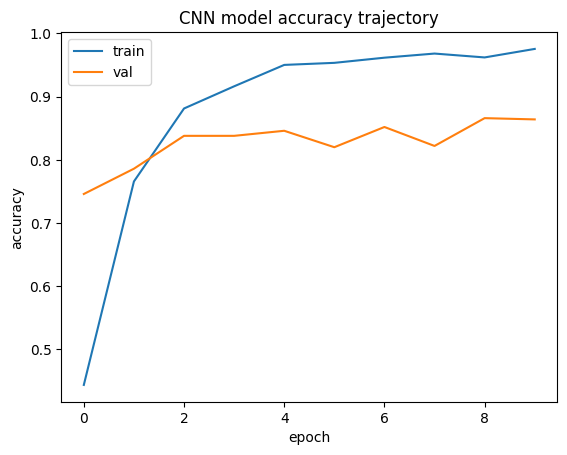

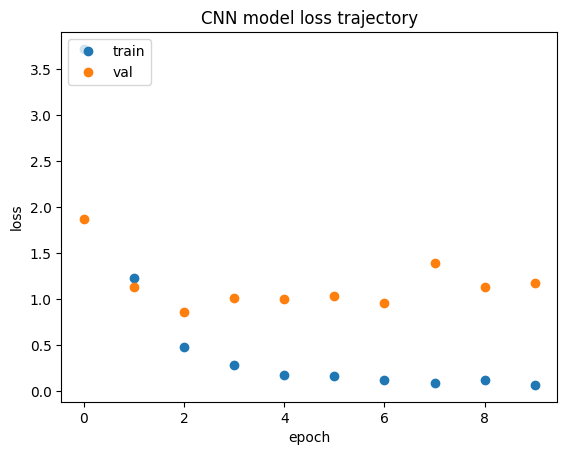

In [10]:
# Plotting accuracy trajectory
plt.plot(cnn_model_1_results.history['accuracy'])
plt.plot(cnn_model_1_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_1_results.history['loss'],'o')
plt.plot(cnn_model_1_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

11/11 [==============================] - 2s 51ms/step
Test accuracy of the CNN model: 0.8262195121951219
   Labels Mapping
0         Alabama
1          Alaska
2         Arizona
3        Arkansas
4      California
5        Colorado
6     Connecticut
7        Delaware
8         Florida
9         Georgia
10         Hawaii
11          Idaho
12       Illinois
13        Indiana
14           Iowa
15         Kansas
16       Kentucky
17      Louisiana
18          Maine
19       Maryland
20  Massachusetts
21       Michigan
22      Minnesota
23    Mississippi
24       Missouri
25        Montana
26       Nebraska
27         Nevada
28   NewHampshire
29      NewJersey
30      NewMexico
31        NewYork
32  NorthCarolina
33    NorthDakota
34           Ohio
35       Oklahoma
36         Oregon
37   Pennsylvania
38    RhodeIsland
39  SouthCarolina
40    SouthDakota
41      Tennessee
42          Texas
43           Utah
44        Vermont
45       Virginia
46     Washington
47   WashingtonDC
48   WestVirg

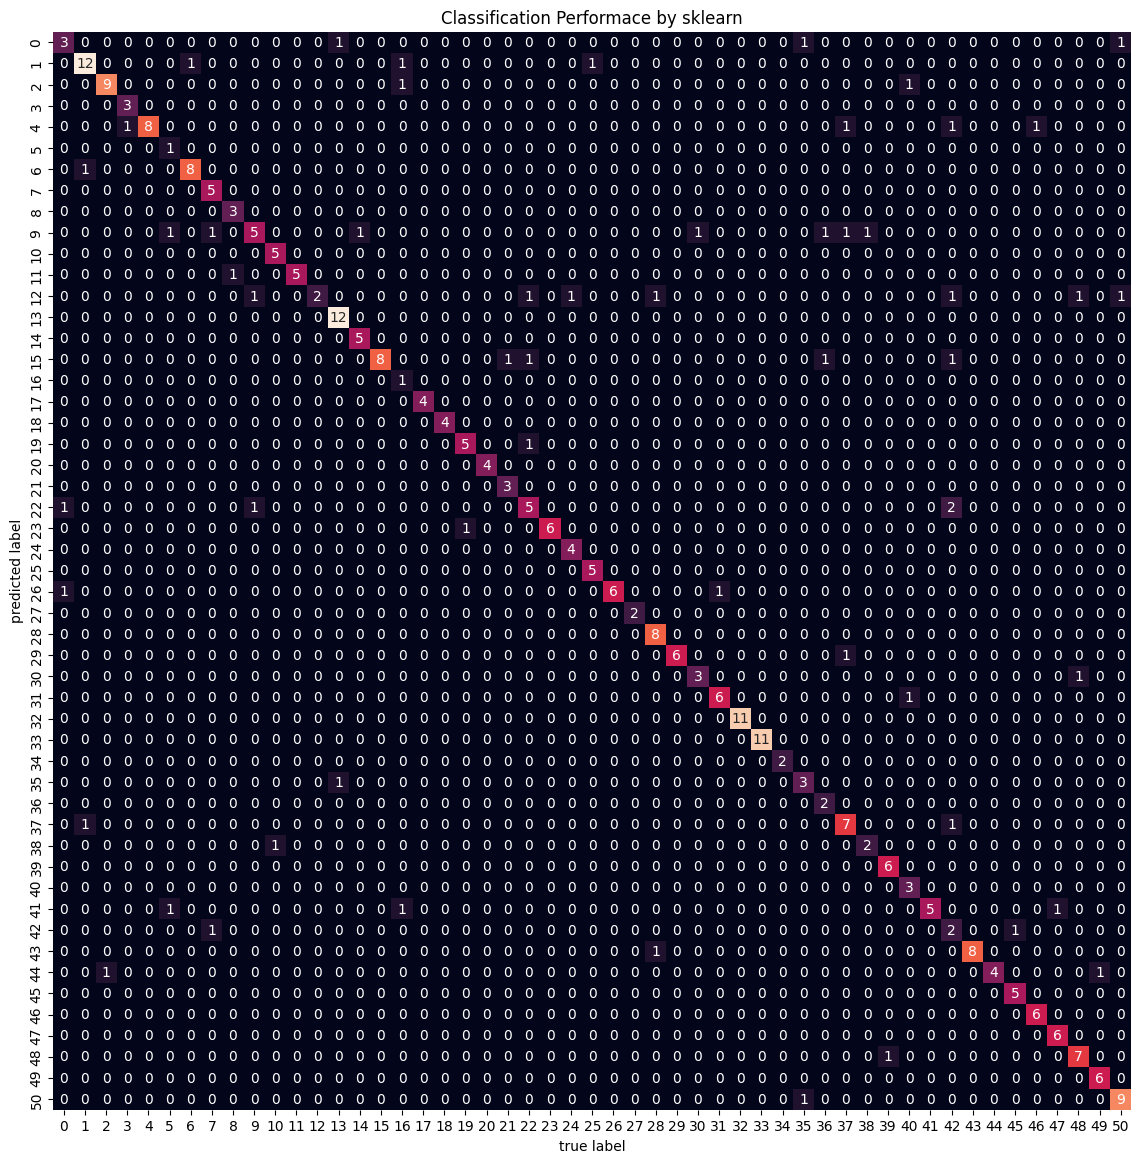

In [11]:
# Make predictions on the test set
cnn_test_predictions = np.argmax(cnn_model_1.predict(test_X), axis=-1)
# Build confusion matrix
cnn_confusion_mat = confusion_matrix(test_Y_transformed, cnn_test_predictions)

# Calculate test accuracy
cnn_score = accuracy_score(test_Y_transformed, cnn_test_predictions)
# Print the test accuracy
print('Test accuracy of the CNN model:', cnn_score)

# Inverse transform the encoded labels to get the original labels
test_Y_labels = encoder.inverse_transform(test_Y_transformed)

# Create a DataFrame
labels_df = pd.DataFrame({
    'Original Label': test_Y_labels,
    'Transformed Label': test_Y_transformed
})

# Get the unique values from the first column and sort them
unique_labels = sorted(labels_df['Original Label'].unique())
# Create a new DataFrame with the unique labels
filtered_df = pd.DataFrame({'Labels Mapping': unique_labels})
# Print the filtered DataFrame
print(filtered_df)

# Plot confusion matrix
plt.figure(figsize=(18, 14))
sns.heatmap(cnn_confusion_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.title('Classification Performace by sklearn')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

As a result, the trained CNNs model was able to predict the test dataset with a 80% accuracy. This indicates that the model performed well in classifying the test data, correctly predicting the States of license plate images with a high level of accuracy. The test accuracy metric serves as an evaluation of the model's performance on unseen data, giving an indication of its generalization capability. However, it's important to consider the specific requirements and context of the project to determine whether this level of accuracy is satisfactory. Depending on the application and the desired level of performance, the achieved accuracy may be considered good or may require further improvements. Factors such as capturing plate images at random angles, in poor lighting conditions, or while in motion can significantly impact the image quality. These challenging conditions may reduce the accuracy of the model's predictions.

To ensure the model's effectiveness in such scenarios, further improvements may be necessary. This could involve additional data augmentation techniques to simulate challenging conditions during training, or exploring advanced techniques like object detection or image enhancement algorithms. Ultimately, the suitability of the achieved accuracy depends on the project's objectives and desired level of performance. It's important to balance the trade-off between accuracy and real-world practicality, considering the challenges and constraints inherent in license plate image recognition tasks.

### (b). Training Model 2: Basic 2 layers Neural Networks 

As a contrast to the CNN model that was built, we now focused our attention on a slightly different but less complex algorithm for constructing our next model. The feedforward neural networks (FFNN) shown below also follow a sequential architecture. This basic two layers neural network as learned in class starts with a flatten process that takes input images and converts it into a 1-dimensional array. These inputs are then fed to the first Dense layer with 256 neurons, that applies the rectified exponential linear unit (ReLU) activation function, which helps the model learn complex, non-linear patterns in the data. This layer contributes to the model's ability to extract meaningful features from the input. To prevent overfitting, a Dropout process is also added to help prevent the model from relying too heavily on specific neurons, promoting better generalization to unseen data. Finally, the model ends with another Dense layer consisting of 51 neurons to produce the output for the 51 classes we have in our classification task using a softmax function.


In [12]:
ffnn_model = Sequential()

ffnn_model.add(Flatten(input_shape=(367, 1000, 1)))
ffnn_model.add(Dense(256, activation='relu'))
ffnn_model.add(Dropout(0.5))
ffnn_model.add(Dense(51, activation='softmax'))  # 51 classes

ffnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 367000)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               93952256  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 51)                13107     
                                                                 
Total params: 93,965,363
Trainable params: 93,965,363
Non-trainable params: 0
_________________________________________________________________


The model is then trained in a similar manner to our first model. For this model, we used 'sparse_categorical_crossentropy' as our loss function during the optimization process since it is suitable for multi-class classification problems with integer labels. 

In [13]:
# Model parameters
learning_rate = 1e-3
epochs = 10
nn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
ffnn_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=nn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
ffnn_model_results = ffnn_model.fit(train_X,
             train_Y,
             batch_size=3,
             epochs=epochs,
             validation_data=(valid_X, valid_Y), verbose=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
817/817 [==============================] - 5s 6ms/step - loss: 5114.3633 - accuracy: 0.0253 - val_loss: 4.0133 - val_accuracy: 0.0320
Epoch 2/10
817/817 [==============================] - 4s 5ms/step - loss: 4.1426 - accuracy: 0.0355 - val_loss: 3.9320 - val_accuracy: 0.0320
Epoch 3/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9252 - accuracy: 0.0355 - val_loss: 3.9325 - val_accuracy: 0.0320
Epoch 4/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9219 - accuracy: 0.0355 - val_loss: 3.9334 - val_accuracy: 0.0320
Epoch 5/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9206 - accuracy: 0.0355 - val_loss: 3.9346 - val_accuracy: 0.0320
Epoch 6/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9198 - accuracy: 0.0355 - val_loss: 3.9355 - val_accuracy: 0.0320
Epoch 7/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9191 - accuracy: 0.0355 - val_loss: 3.9364 - val_accuracy: 0.0320
Epo

 These results show the training and validation loss values, as well as the training and validation accuracy values at each epoch. It appears that the model is not learning effectively, as the loss and accuracy values do not show significant improvements over the epochs. The training and validation accuracies remain consistently low at approximately 3%, and the loss values remain high at 3.93 as shown in the plotted figures below.

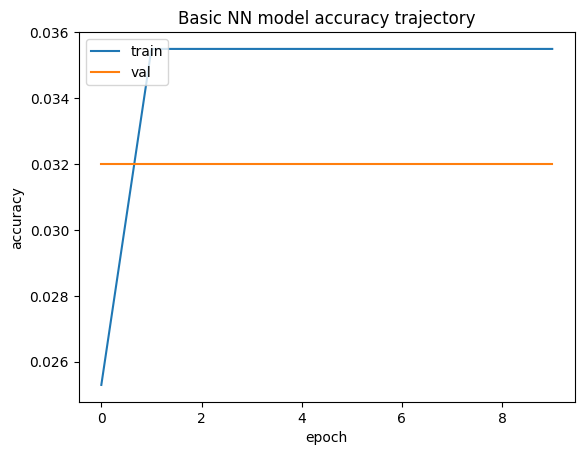

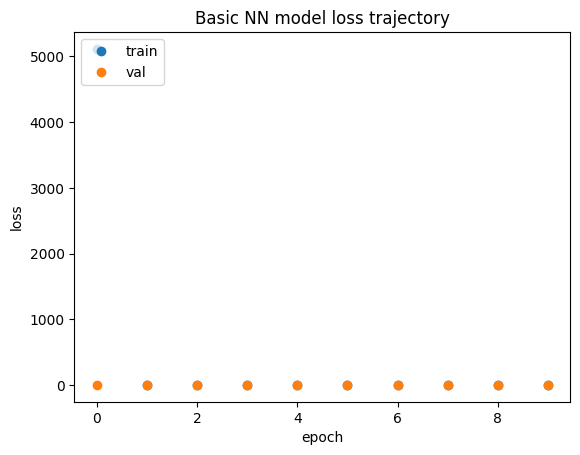

In [14]:
# Plotting accuracy trajectory
plt.plot(ffnn_model_results.history['accuracy'])
plt.plot(ffnn_model_results.history['val_accuracy'])
plt.title('Basic NN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(ffnn_model_results.history['loss'],'o')
plt.plot(ffnn_model_results.history['val_loss'],'o')
plt.title('Basic NN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

11/11 [==============================] - 0s 4ms/step
Test accuracy of the FFNN model: 0.042682926829268296


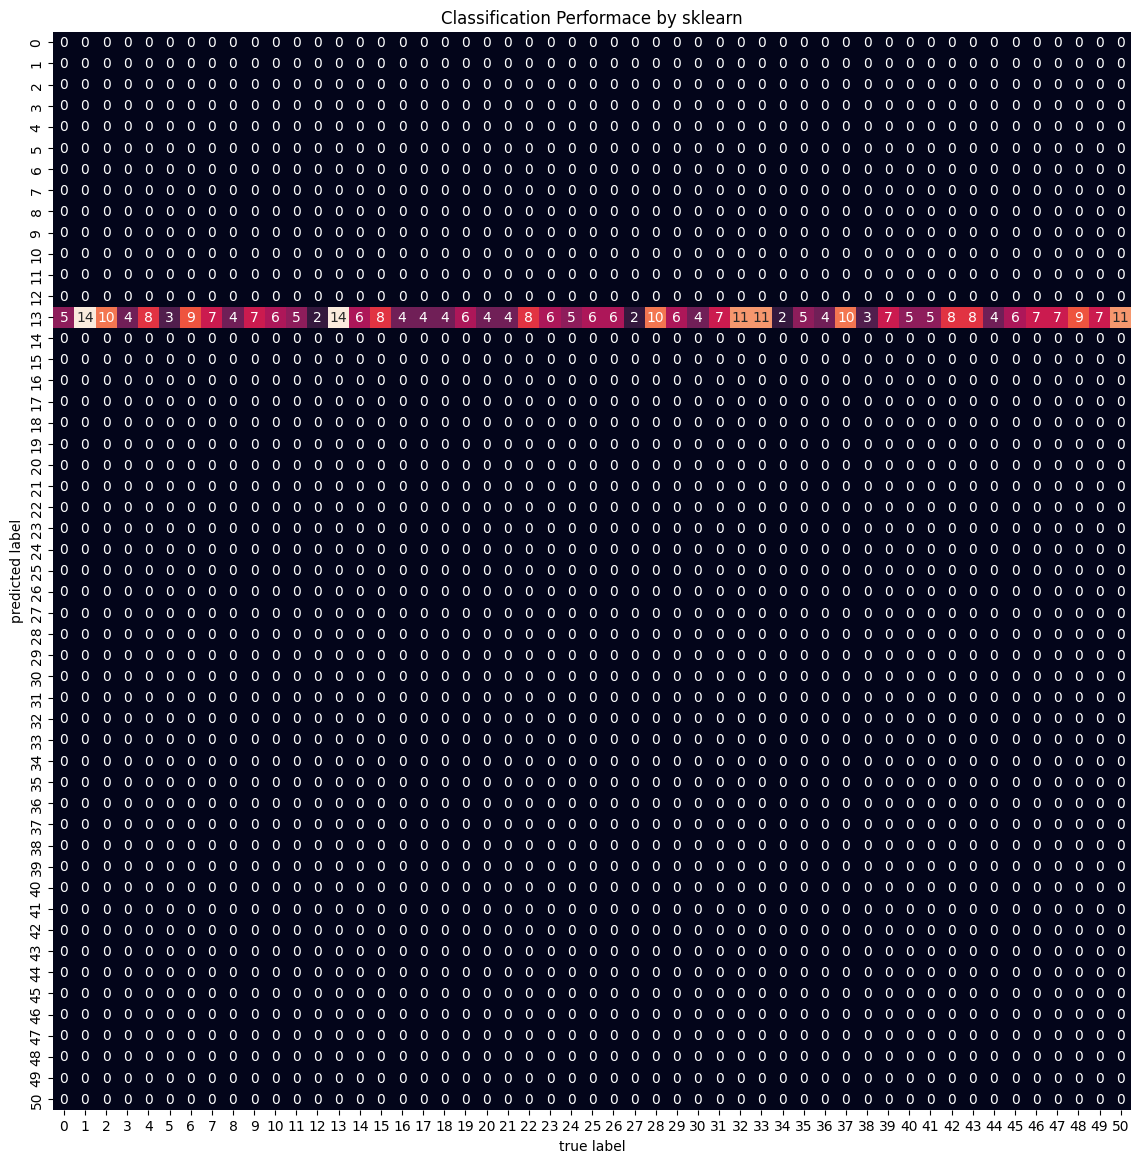

In [15]:
## Testing the 2 layer NN model 
# Make predictions on the test set
nn_test_predictions = np.argmax(ffnn_model.predict(test_X), axis=-1)
# Build confusion matrix
nn_confusion_mat = confusion_matrix(test_Y_transformed, nn_test_predictions)

# Calculate test accuracy
nn_score = accuracy_score(test_Y_transformed, nn_test_predictions)
# Print the test accuracy
print('Test accuracy of the FFNN model:', nn_score)

# Plot confusion matrix
plt.figure(figsize=(18, 14))
sns.heatmap(nn_confusion_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.title('Classification Performace by sklearn')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

As expected, it also perform poorly when predicting the test dataset. One of the main reasons that lead to this poor prediction result of 4.26% is due to the fact that the model is too simple to effectively classify complex images. This FFNN model is a basic 2-layer fully connected neural network that lacks the ability to capture any meaningful spatial relationships and patterns within the images. These images as visualized earlier contained intricate details and local features that required more sophisticated models, such as convolutional neural networks (CNN) to extract and analyze.

 CNNs are specifically designed for image classification tasks as they took the advantage of convolution layers to capture local patterns and heirarchical representation.  In order to improve the prediction accuracy, it is recommended to explore the use of CNNs instead of the FFNN model. By incorporating convolutional and pooling layers, the CNN model would be able to learn and extract relevant features from the license plate images, leading to more accurate predictions. Additionally, increasing the complexity of the model by adding more layers or adjusting the architecture can also enhance its predictive performance.

### (c). Training Model 3: ResNet50

The third model that we have used is a "ResNet50 model", which is a deep convolutional neural network architecture best known for its excellent performance in image classification tasks. This model provided by Keras has been pre-trained on the large-scale ImageNet dataset with millions of labeled images across various categories. For this model, we define the shape of the input images to be (367, 1000, 3) since the ResNet50 model only works on images with more than 1 color channel. Similarly, we also applied an additional flattening layer to flatten the output from the base model followed by a dense layer that takes these flattened outputs and produces the final classification probabilities for the 51 classes.

In [16]:
#res net needs more than 1 color channel
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(367, 1000, 3))
x = base_model.output
x = Flatten()(x)
predictions = Dense(51, activation='softmax')(x) 

resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 367, 1000,   0           []                               
                                3)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 373, 1006, 3  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 184, 500, 64  9472        ['conv1_pad[0][0]']              
                             

Due to the size and the complexity of the model, we decided to train it for only 6 epochs and it is observed that this model still outdid the CNNs model at predicting the validation dataset with the highest accuracy achieved in the fourth epoch at 90%. One downside to this model is that the training process becomes such a daunting task to the CPU. With the helps of GPU as the accelarator, each epoch still take almost 4 minutes to complete on the colab notebook ran with a runtime that utilized GPU as the performance accelator.     

In [24]:
# Model parameters
learning_rate = 1e-3
epochs = 6
resnet_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
resnet_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=resnet_optimizer,
                 metrics=['accuracy'])

train_X_3layer = np.repeat(train_X[..., np.newaxis], 3, -1)
valid_X_3layer = np.repeat(valid_X[..., np.newaxis], 3, -1)

# Training and validating the model
resnet_model_results = resnet_model.fit(train_X_3layer,
             train_Y,
             batch_size=3,
             epochs=epochs,
             validation_data=(valid_X_3layer, valid_Y), verbose=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/6
817/817 [==============================] - 45s 48ms/step - loss: 0.0532 - accuracy: 0.9959 - val_loss: 4.1180 - val_accuracy: 0.8760
Epoch 2/6
817/817 [==============================] - 38s 47ms/step - loss: 0.1783 - accuracy: 0.9882 - val_loss: 6.4262 - val_accuracy: 0.8460
Epoch 3/6
817/817 [==============================] - 38s 47ms/step - loss: 0.1832 - accuracy: 0.9898 - val_loss: 6.5247 - val_accuracy: 0.8820
Epoch 4/6
817/817 [==============================] - 38s 47ms/step - loss: 0.0786 - accuracy: 0.9951 - val_loss: 4.5562 - val_accuracy: 0.8960
Epoch 5/6
817/817 [==============================] - 38s 47ms/step - loss: 0.0298 - accuracy: 0.9967 - val_loss: 5.1134 - val_accuracy: 0.8780
Epoch 6/6
817/817 [==============================] - 38s 47ms/step - loss: 0.0677 - accuracy: 0.9939 - val_loss: 4.9090 - val_accuracy: 0.8880


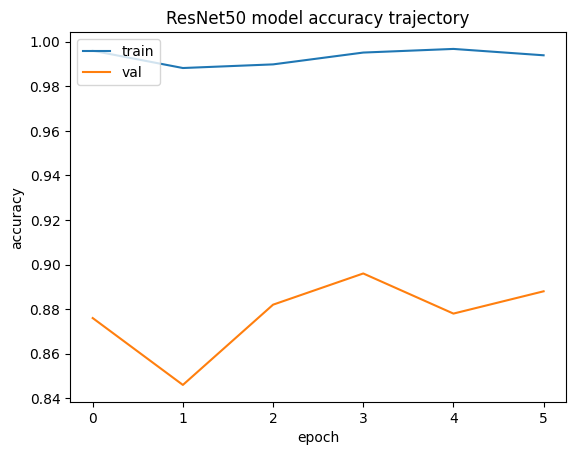

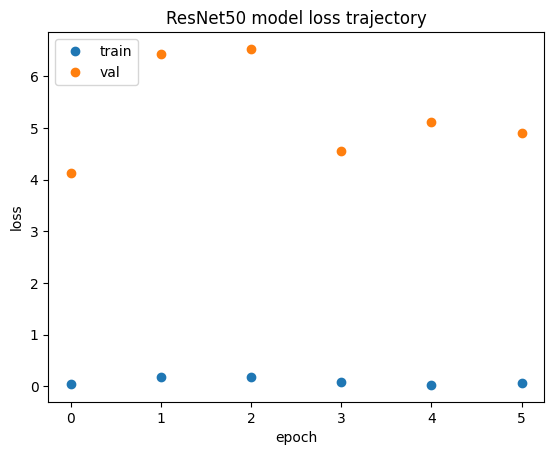

In [25]:
# Plotting accuracy trajectory
plt.plot(resnet_model_results.history['accuracy'])
plt.plot(resnet_model_results.history['val_accuracy'])
plt.title('ResNet50 model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(resnet_model_results.history['loss'],'o')
plt.plot(resnet_model_results.history['val_loss'],'o')
plt.title('ResNet50 model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

11/11 [==============================] - 2s 80ms/step
Test accuracy of the ResNet model: 0.850609756097561


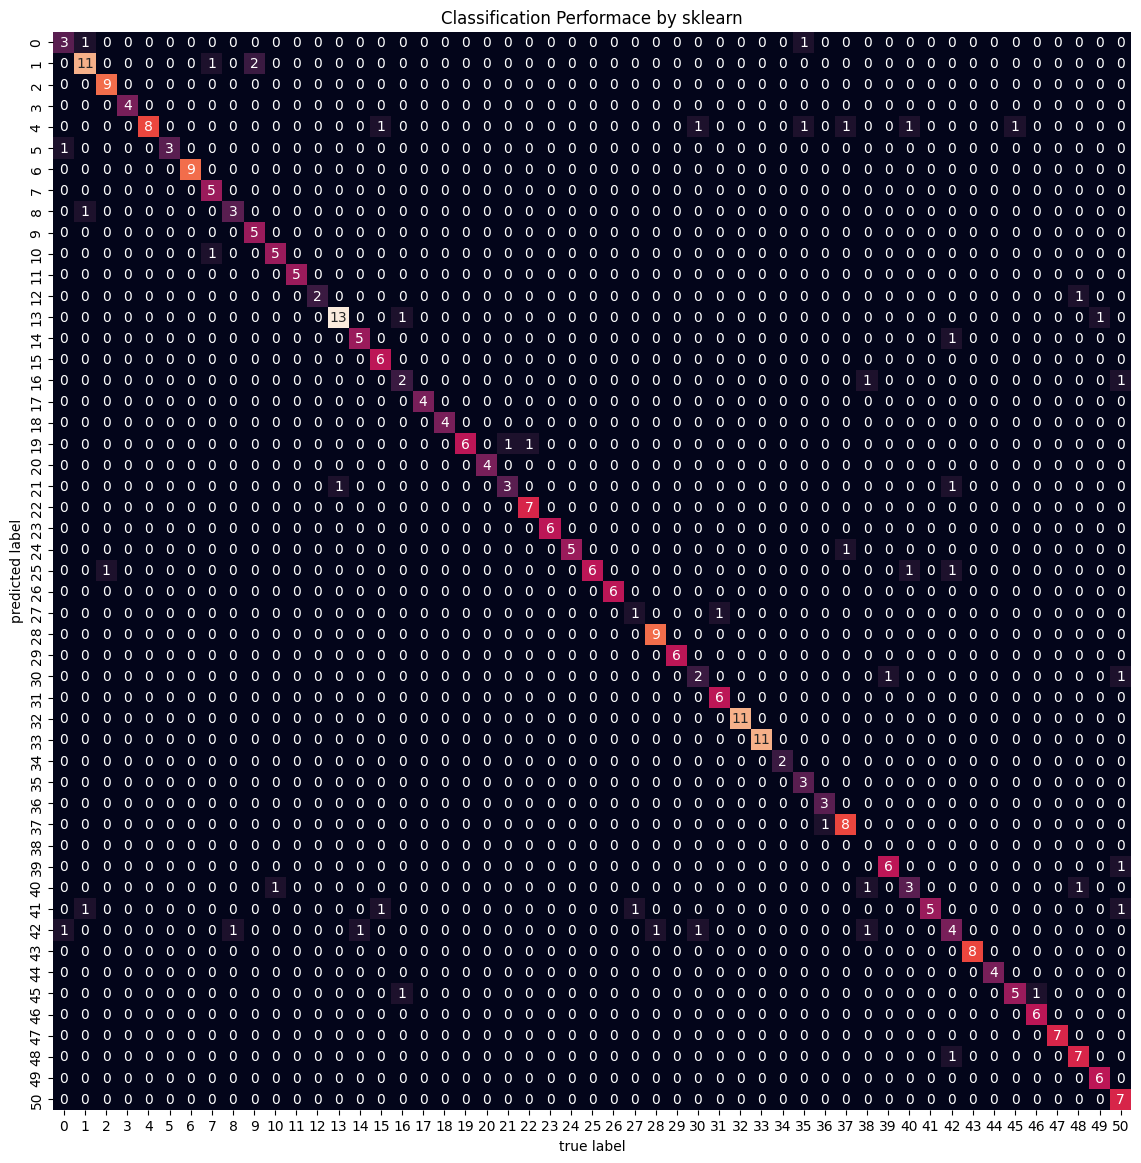

In [26]:
# Testing the ResNet50 NN model 
test_X_3layer = np.repeat(test_X[..., np.newaxis], 3, -1)
# Make predictions on the test set
resnet_test_predictions = np.argmax(resnet_model.predict(test_X_3layer), axis=-1)
# Build confusion matrix
resnet_confusion_mat = confusion_matrix(test_Y_transformed, resnet_test_predictions)

# Calculate test accuracy
resnet_score = accuracy_score(test_Y_transformed, resnet_test_predictions)
# Print the test accuracy
print('Test accuracy of the ResNet model:', resnet_score)

# Plot confusion matrix
plt.figure(figsize=(18, 14))
sns.heatmap(resnet_confusion_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.title('Classification Performace by sklearn')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

A test accuracy of over 85% was achieved using this model for prediction. 

### (iv) Model Comparison and Visualization

In [32]:
from sklearn.metrics import f1_score

y_pred_prob = cnn_model_1.predict(test_X)
y_pred = np.argmax(y_pred_prob, axis=1)
f1 = f1_score(test_Y_transformed, y_pred, average = "weighted")
print("CNN F1 score:", f1)

y_pred_prob = ffnn_model.predict(test_X)
y_pred = np.argmax(y_pred_prob, axis=1)
f1 = f1_score(test_Y_transformed, y_pred, average = "weighted")
print("NN F1 score:", f1)

y_pred_prob = resnet_model.predict(test_X_3layer)
y_pred = np.argmax(y_pred_prob, axis=1)
f1 = f1_score(test_Y_transformed, y_pred, average = "weighted")
print("ResNet F1 score:", f1)

11/11 [==============================] - 0s 28ms/step
CNN F1 score: 0.8289886938153135
11/11 [==============================] - 0s 4ms/step
NN F1 score: 0.00349450862929682
11/11 [==============================] - 1s 79ms/step
ResNet F1 score: 0.8507785325301638


We used train, validation, and test accuracy as well as F1 scores as our evaluation metrices. We will compare the performance of the models by comparing the mentioned evaluation metrices. The following grid displays the overall best acurracies, and do note that they are not from same epochs as the accuracies are very similar to each other when they are at the maximum.

  <table>
  <tr>
    <th>Model</th>
    <th>Train Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>CNN (Model 1)</td>
    <td>0.988</td>
    <td>0.866</td>
    <td>0.828</td>
  </tr>
  <tr>
    <td>NN (Model 2)</td>
    <td>0.035</td>
    <td>0.032</td>
    <td>0.042</td>
  </tr>
  <tr>
    <td>ResNet (Model 3)</td>
    <td>0.996</td>
    <td>0.896</td>
    <td>0.851</td>
  </tr>
</table>

Although determining the best-performing model is challenging, we can conclude that Model 2 performed poorly due to its lack of layers. Networks with more layers can capture spatial and local features more effectively. Unfortunately, our basic NNs model had only two layers, leading to subpar performance in the task. We can also note that by a slight margin, ResNet outperformed CNN in case of both accuracies and F1 scores. CNN is known for its strong feature extraction capabilities in image processing tasks, while ResNet excels with large datasets and addresses the vanishing gradient problem. As our task involved image processing on a relatively large dataset, ResNet architecture contributed to its better performance compared to CNN but also at the cost of a longer training time and huge memory consumption. 

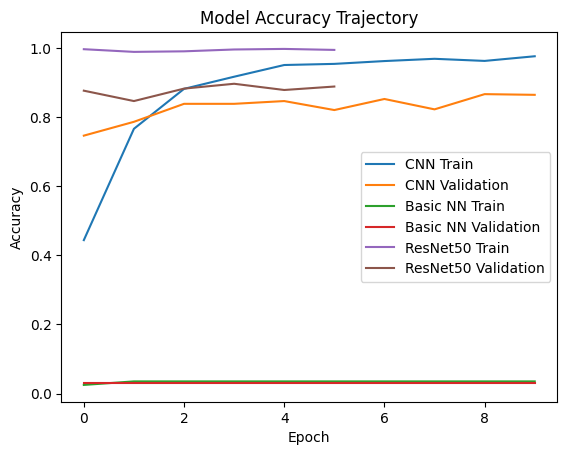

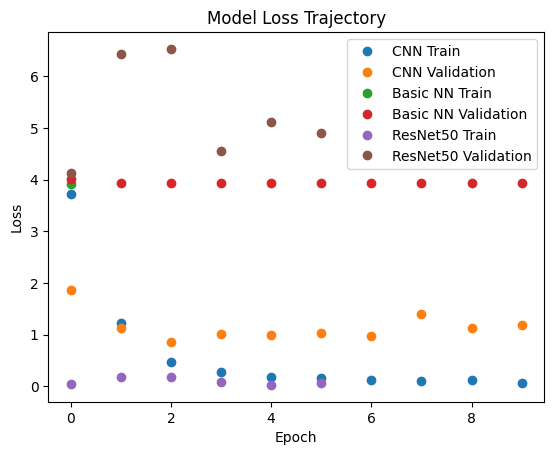

In [33]:
#This combines accuracy graphs together, and loss graphs together. I can't run it because I haven't trained the other ones! pls run it when u can and delete this comment!

# Plotting accuracy trajectory
plt.plot(cnn_model_1_results.history['accuracy'])
plt.plot(cnn_model_1_results.history['val_accuracy'])
plt.plot(ffnn_model_results.history['accuracy'])
plt.plot(ffnn_model_results.history['val_accuracy'])
plt.plot(resnet_model_results.history['accuracy'])
plt.plot(resnet_model_results.history['val_accuracy'])

plt.title('Model Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Train', 'CNN Validation', 'Basic NN Train', 'Basic NN Validation', 'ResNet50 Train', 'ResNet50 Validation'])
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_1_results.history['loss'],'o')
plt.plot(cnn_model_1_results.history['val_loss'],'o')
plt.plot(ffnn_model_results.history['loss'][-1],'o')
plt.plot(ffnn_model_results.history['val_loss'],'o')
plt.plot(resnet_model_results.history['loss'],'o')
plt.plot(resnet_model_results.history['val_loss'],'o')

plt.title('Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['CNN Train', 'CNN Validation', 'Basic NN Train', 'Basic NN Validation', 'ResNet50 Train', 'ResNet50 Validation'])
plt.show()

---
## END